# Homework 7

In this homework you will be training and using a "char-RNN". This is the name given to a character-level recurrent neural network language model by [this famous blog post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Before you start on the rest of the homework, please give the blog post a read, it's quite good!

I don't expect you to implement the char-RNN from scratch. Andrej's original char-rnn is in Torch (the predecessor to PyTorch that is not commonly used anymore). Fortunately, there are many other implementations of this model available; for example, there is one (in both mxnet and pytorch) in chapters 8 and 9 of [the textbook](http://d2l.ai), and another pytorch one [here](https://github.com/spro/char-rnn.pytorch). **Please use one of these example implementations (or another one that you find) when completing this homework**.

For this homework, please complete the following steps:

1. Download and tokenize the [Shakespeare dataset](http://www.gutenberg.org/files/100/100-0.txt) at a character level. I recommend basing your solution on the following code:
```Python
# Remove non-alphabetical characters, lowercase, and replace whitespace with ' '
raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
# Maps token index to character
idx_to_char = list(set(raw_dataset))
# Maps character to token index
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
# Tokenize the dataset
corpus_indices = [char_to_idx[char] for char in raw_dataset]
```
1. Train a "vanilla" RNN (as described in chapter 8 of [the textbook](http://d2l.ai)) on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.
1. Train a GRU RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?
1. Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
import time
import random
import string
import math
import torch
import torchtext.utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.distributions import Categorical
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import re

all_characters = string.printable
n_characters = len(all_characters)

dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
torchtext.utils.download_from_url(url=dataset_file_origin,root='data',overwrite=True)
file = open('data/shakespeare.txt', mode='r').read()
file_len = len(file)
print('Length of text: {} characters'.format(len(file)))

Mounted at /content/drive


100%|██████████| 1.12M/1.12M [00:00<00:00, 108MB/s]

Length of text: 1115394 characters


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [4]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

er's bloody axe.
Ah, Gaunt, his blood was thine! that bed, that womb,
That metal, that self-mould, that fashion'd thee
Made him a man; and though thou livest and breathest,
Yet art thou slain in him: t


In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

Vanilla RNN:

In [6]:
class Vanilla(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Vanilla, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        r_output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.dropout(r_output)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [7]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

In [8]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    
    return inp, target

In [9]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [10]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [12]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = Vanilla(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set()
    loss = train(inp,target)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


 17s (100 5%) 2.4851]
Why madan I and of mans fin cor yous my meips ard toe and hallt tads mod saseer hend youll make ans fa 

 30s (200 10%) 2.4326]
Whour ourlere: ther fithisester fof-mastast thers il my ond youedr.

MARUHI
M:
A heron enreingalh in b 

 42s (300 15%) 2.3210]
Whast?

DUCE: MThen bames cumes. wherved need helver thanushy enst'llo thed frone sten mon his, hither 

 55s (400 20%) 2.1778]
Whad I venpof hat ande ffithe der the thealas noth may andars.

KATBUCETETHANE:
Yo the wimt of the ar  

 7s (500 25%) 2.1516]
Whoft and shands wast ut and to the the our the hord hands you rest cares:
I sme of look. jith ingey b 

 22s (600 30%) 1.8718]
Wheed the priel here to dee wary have shou of I hime pimeat he day so dood, his lind he gore ir the d. 

 35s (700 35%) 2.1511]
Whicinged and bere bears come of by youl in thut in sonds well I in the sell Losly on miness now his b 

 47s (800 40%) 2.2642]
Wht bo not sthe grot wear love tow the his diand faard.

Tither pan brele of this g

Text(0.5, 1.0, 'Vanilla RNN - Loss Plot')

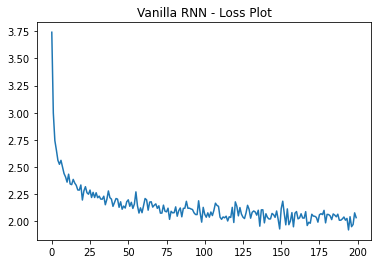

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.title('Vanilla RNN - Loss Plot')

In [14]:
print(evaluate('Th', 200, temperature=0.8))

Thild thee;
Mardy in from:
Westeet hehe come frople loldies,
Wrady;
Now it wrall that I hast use prom come, hald, chingul sandect; the him the dechat then well be your nom bid ganous take of; of have se


In [15]:
print(evaluate('Th', 200, temperature=0.2))

This the bear the him the comes a mark heart mart and and the come your the come be your thee are a dood the the but be more the there the comes the the the promes the hath and thee hath the beat and ma


In [16]:
print(evaluate('Th', 200, temperature=1.4))

Thull than lquio nlubvehs Kind d-quich? teet,-Gack, Pade'ys,
Cich nimbest your Tpilkwarrs
And nakh?' teticrih an mowheneringe come
Buspnu`x muwbuld twornb, Niclo
Hordch:
Whimice.
Eo, wellach,' the cFor 


GRU RNN:

The training loss for the GRU RNN is lower than the Vanilla RNN. The training loss for the Vanilla RNN is around 2.0, while the training loss for the GRU RNN is around 1.75, so the GRU RNN performs slightly better. The sample predictions are also slightly more realistic. When comparing the temperature of 0.8, the Vanilla RNN is producing a lot less real words than the GRU RNN, where most of the words are real but are not comprehensible when put together. For both, the temperature of 0.8 produces the best predictions while 0.2 repeats the same words and 1.4 does not produce legible text.

In [17]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = GRU(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set()
    loss = train(inp,target)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 17s (100 5%) 2.4506]
Whe
no wo bust weresty id lomer allis hithe met porer corusken Bith'y walce ainfe fis the.

Fat youn a 

 33s (200 10%) 2.2747]
Whove of and;
Y le, chat mond and nit condlet tho is is cuan hausrann
Wichon supince lone bus say gond 

 49s (300 15%) 2.1553]
Why
'Then an a
A de well!
I the ance mis mnets and blood the ar soo mave the the for meart, king men h 

 5s (400 20%) 2.1836]
Whave the to my alion.

YORK:
To wien wrought, thee, to shand, trene to that thy the was,
Twon'd will  

 21s (500 25%) 2.0073]
What this I the gretrest notme not.
So drefore your my pried for of there shall With like or men for u 

 37s (600 30%) 2.1036]
Who give from I come, this his me his you crown good hat I thou he mepphit maiding.

PTive. OF I prith 

 52s (700 35%) 1.9168]
What mad in player.

PETRUCHIO:
Whot in these's that here that fath ad gose
And wat sill and well bori 

 9s (800 40%) 1.8442]
Whe bethert thing to supt to tome I our gearse,
The had as your of the shal?
Sayser;

Text(0.5, 1.0, 'GRU RNN - Loss Plot')

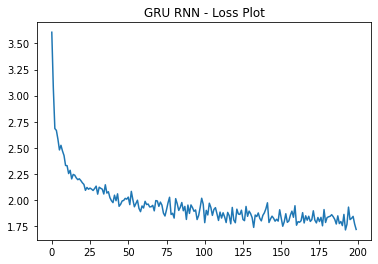

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.title('GRU RNN - Loss Plot')

In [19]:
print(evaluate('Th', 200, temperature=0.8))

That a sid,
Murst a lieching thy till.

KING EDWARD IV:
Waratly, and shall to treep the, ing comforse a bewered
To thage such the worder and should an thou connow, the daid
Thaser of my so so Dibless is


In [20]:
print(evaluate('Th', 200, temperature=0.2))

Thand the were the mand,
To shall and and the will and your strove and some to make the shollow and your comest and and the reave the will and your and to my lord,
The should a some and make the good an


In [21]:
print(evaluate('Th', 200, temperature=1.4))

This ar yie nobe,
Dived bid al:
Rome you: and Swrown; warderremonter'd; nokis fore shall.
Shen baning, Enre,
Hys the brome your unrius:
That my glaivel then yemptand arief;
From teil!
I decep tius a'tri


In [24]:
file = open('drive/MyDrive/pg.txt', mode='r').read()
file = ' '.join(re.sub('[^A-Za-z ]+', '', file).split())
file_len = len(file)
print('Length of text: {} characters'.format(len(file)))

Length of text: 48676 characters


Paul Graham Essay:

The training loss for the Paul Graham Essay data is the lowest, with a loss of around 1.0. I ran the GRU RNN on the Paul Graham Essay data, so this data is performing better than the Shakespeare data. 

In [25]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = GRU(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set()
    loss = train(inp,target)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 15s (100 5%) 1.8507]
Whetime preartucther intang the sto sed th the startum ding of fos lot memom a a the int the oure atn  

 32s (200 10%) 1.7520]
When cob of is to be were to the would a peoppe a the see most peot the exed the lerd ide an the sotar 

 49s (300 15%) 1.5112]
Why have the woce dony about ao who do is startup you can loul aboud a lo componess succicase more who 

 5s (400 20%) 1.5755]
Wher to seem you may yide of donting who smas betitu some is the of ung BCction a startups by brvience 

 21s (500 25%) 1.7887]
Wh is be teplers the if the startup extent on experiengel with the rose a could be the rising thas the 

 37s (600 30%) 1.5553]
When to do problem a sepe working ont the company and the someth Them working your in they have not th 

 53s (700 35%) 1.4622]
Whe with I world would be company to surpries money decided first that company to worked on the othen  

 9s (800 40%) 1.3119]
Whe you make imect diend it whers to startup its a startup is with way to startups I

Text(0.5, 1.0, 'Paul Graham Essays with GRU RNN - Loss Plot')

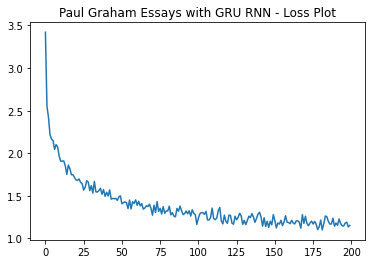

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.title('Paul Graham Essays with GRU RNN - Loss Plot')

In [31]:
print(evaluate('Th', 200, temperature=0.8))

The probably advant you wathy kerely as are to programmers a consuble to be about the going to be a bat expertentions about the patples the problem what youre fordicould to be dont of sign its a seem to


In [28]:
print(evaluate('Th', 200, temperature=0.2))

The problem them been the something the problem well the world and the problem were the startup is a supposed them the most people when you have to all the problem of the world a supposed to be them bet


In [29]:
print(evaluate('Th', 200, temperature=1.4))

Than they cad experine them programuang surprttly them eveghach comeppted them coupts a arik at smalleters sidce than can exest perum Anyrels woldfers findrvy qourve whech makes gets you hard can a nubi
